In [149]:
import pandas as pd 
import seaborn as sns 
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [150]:
df_divisas = pd.read_csv("C:/Practica_Analisis_De_Datos/monedas_completo.csv")

In [151]:
df_divisas

,fecha,moneda,valor
0,2025-10-01,USD,1.173379
1,2025-10-01,COP,4553.307498
2,2025-10-01,MXN,21.574520
3,2025-09-30,USD,1.173530
4,2025-09-30,COP,4607.867346
...,...,...,...
430,2025-05-12,COP,4687.369980
431,2025-05-12,MXN,21.771759
432,2025-05-11,USD,1.122926
433,2025-05-11,COP,4770.977372


Pivoteando para hacer las monedas columnas

In [152]:
df_divisas = df_divisas.pivot_table(values="valor",columns="moneda",index="fecha")
df_divisas

moneda,COP,MXN,USD
fecha,,,
2025-05-11,4770.977372,21.834844,1.122926
2025-05-12,4687.369980,21.771759,1.109502
2025-05-13,4710.919431,21.708052,1.118518
2025-05-14,4703.826909,21.676348,1.118162
2025-05-15,4702.452110,21.806607,1.119232
...,...,...,...
2025-09-27,4556.938619,21.490324,1.170254
2025-09-28,4566.956741,21.496285,1.170681
2025-09-29,4599.499346,21.540663,1.173117


Se añade una columna EUR que es nuestra moneda de referencia

In [153]:
df_divisas["EUR"] = np.ones(df_divisas.shape[0])
df_divisas.reset_index(inplace=True)
df_divisas

moneda,fecha,COP,MXN,USD,EUR
0,2025-05-11,4770.977372,21.834844,1.122926,1.0
1,2025-05-12,4687.369980,21.771759,1.109502,1.0
2,2025-05-13,4710.919431,21.708052,1.118518,1.0
3,2025-05-14,4703.826909,21.676348,1.118162,1.0
4,2025-05-15,4702.452110,21.806607,1.119232,1.0
...,...,...,...,...,...
139,2025-09-27,4556.938619,21.490324,1.170254,1.0
140,2025-09-28,4566.956741,21.496285,1.170681,1.0
141,2025-09-29,4599.499346,21.540663,1.173117,1.0
142,2025-09-30,4607.867346,21.495540,1.173530,1.0


Se separa la fecha en dia,mes y año

In [154]:
df_divisas["fecha"] = pd.to_datetime(df_divisas["fecha"])
df_divisas["Dia"] = df_divisas["fecha"].dt.day
df_divisas["Mes"] = df_divisas["fecha"].dt.month
df_divisas["Año"] = df_divisas["fecha"].dt.year

In [155]:
df_divisas

moneda,fecha,COP,MXN,USD,EUR,Dia,Mes,Año
0,2025-05-11,4770.977372,21.834844,1.122926,1.0,11,5,2025
1,2025-05-12,4687.369980,21.771759,1.109502,1.0,12,5,2025
2,2025-05-13,4710.919431,21.708052,1.118518,1.0,13,5,2025
3,2025-05-14,4703.826909,21.676348,1.118162,1.0,14,5,2025
4,2025-05-15,4702.452110,21.806607,1.119232,1.0,15,5,2025
...,...,...,...,...,...,...,...,...
139,2025-09-27,4556.938619,21.490324,1.170254,1.0,27,9,2025
140,2025-09-28,4566.956741,21.496285,1.170681,1.0,28,9,2025
141,2025-09-29,4599.499346,21.540663,1.173117,1.0,29,9,2025
142,2025-09-30,4607.867346,21.495540,1.173530,1.0,30,9,2025


Funcion que filtra por mes y grafica por dia del mes seleccionado para la moneda deseada



In [156]:
def grafica_dias_del_mes(moneda: str, mes: int):
    df_dias_mes = df_divisas.loc[df_divisas["Mes"] == mes]
    plt.figure(figsize=(14,8))
    sns.lineplot(data=df_dias_mes, x="Dia", y=moneda)
    plt.title(f"Evolución de {moneda} en el mes {mes} del año 2025")
    plt.xlabel("Día")
    plt.ylabel(moneda)
    plt.show()


Grafica por dias de COP en el mes 6(junio)

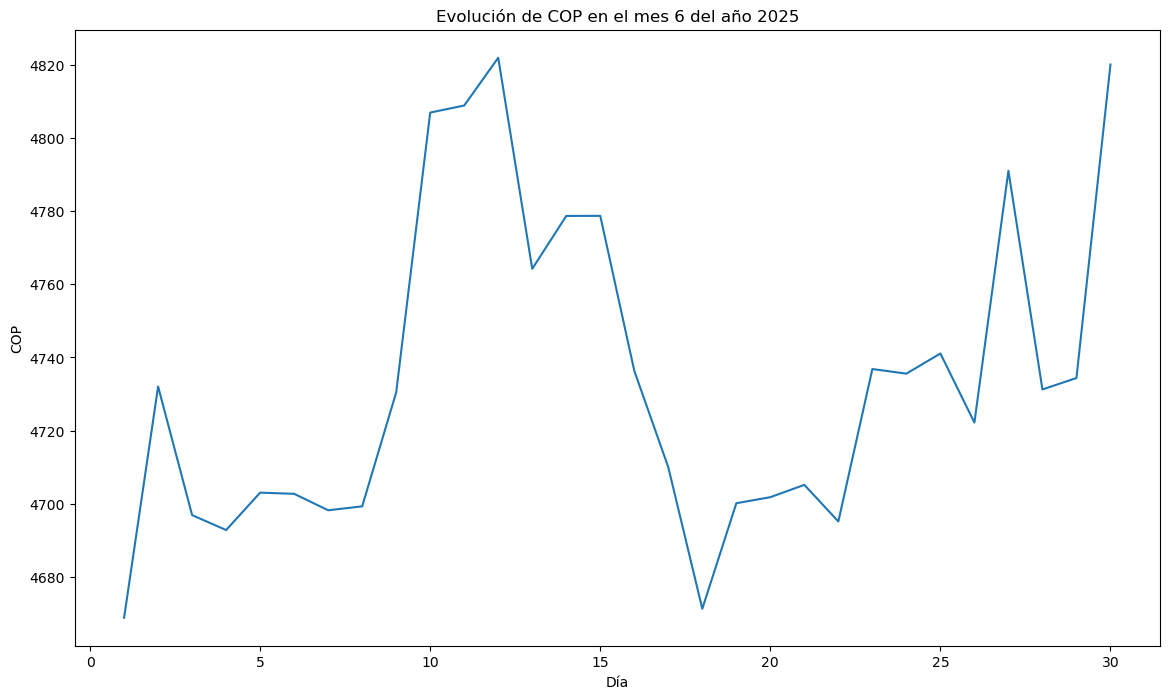

In [157]:
grafica_dias_del_mes("COP",6)

Grafica por dias de USD en el mes 8(agosto)

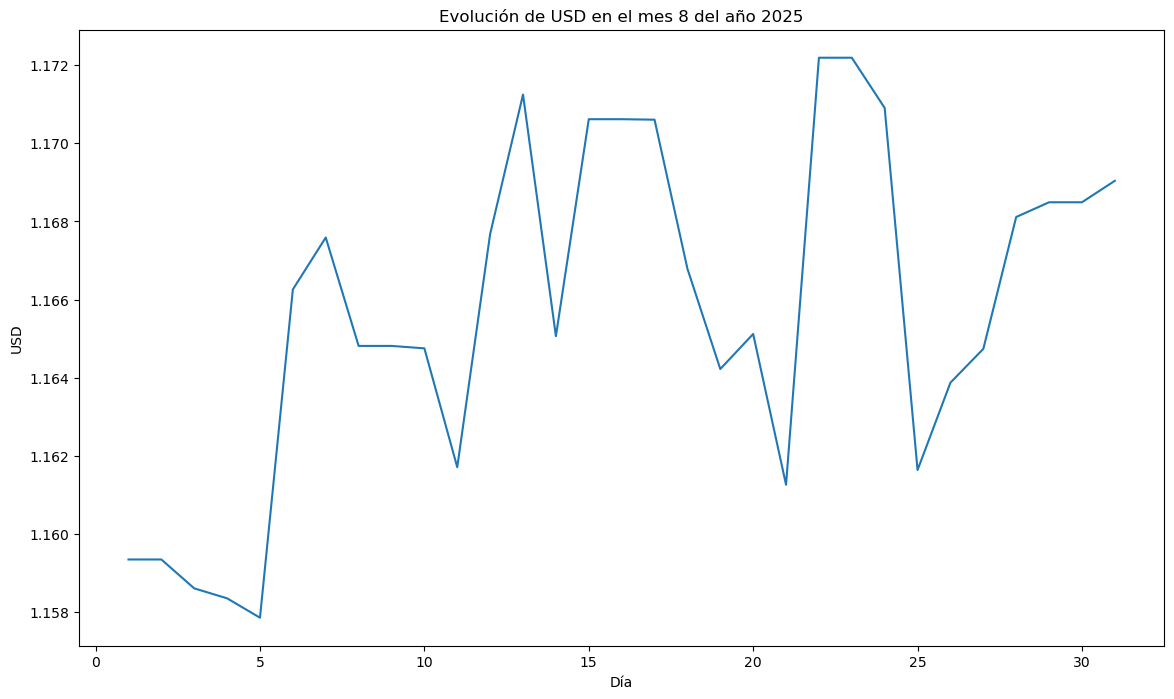

In [158]:
grafica_dias_del_mes("USD",8)

Grafica por dias de MXN en el mes 7(julio)

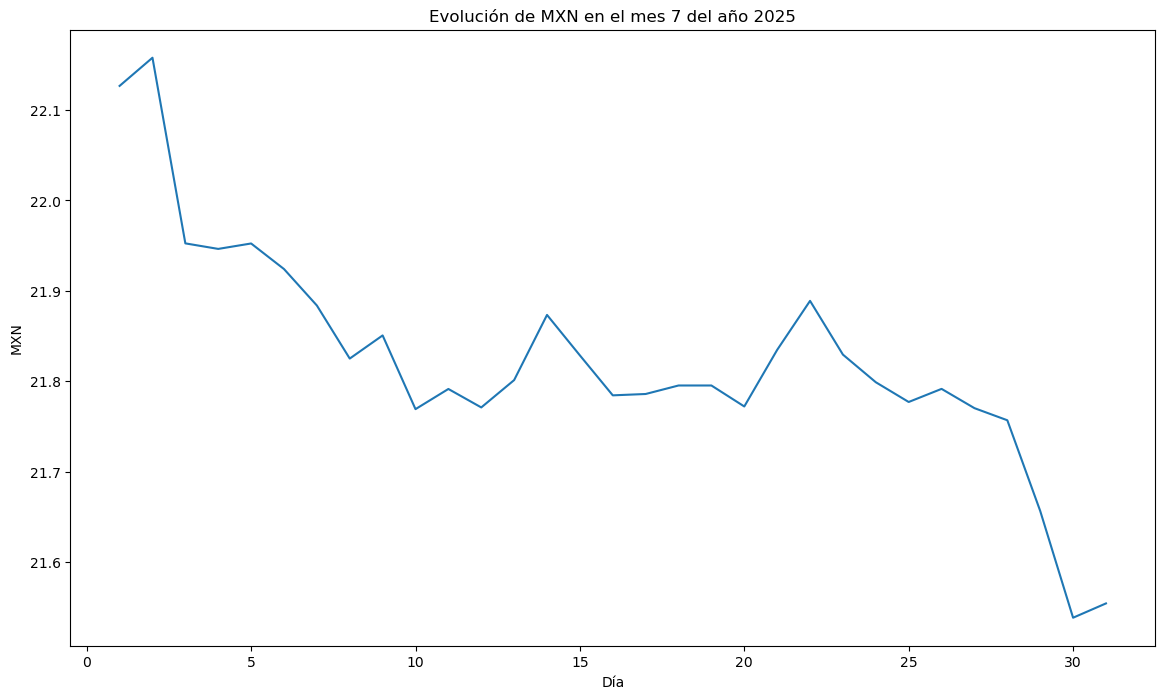

In [159]:
grafica_dias_del_mes("MXN",7)

Analizando se ve que la regresion lineal no es adecuada, se propone una regresion polinomica para predecir el valor segun el dia y el mes

FUNCION PARA GRAFICAR SEGUN LA MONEDA DESEADA

In [160]:
def graficar_prediccion_moneda(moneda:str,grado_polinomio:int):
    # Preparar datos
    x = df_divisas[["Mes", "Dia"]]
    y = df_divisas[moneda]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=50)
    
    # Modelo 
    polinomio = PolynomialFeatures(degree=grado_polinomio)
    x_polinomio = polinomio.fit_transform(x_train)
    modelo = LinearRegression()
    modelo.fit(x_polinomio, y_train)
    
    # Predicción
    x_polinomio_test = polinomio.transform(x_test)
    prediccion = modelo.predict(x_polinomio_test)
    
    # R2
    r2_train = modelo.score(x_polinomio, y_train)
    r2_test = r2_score(y_test, prediccion)
    
    # Fecha para graficar
    fechas_test = df_divisas.loc[x_test.index, 'fecha']
    df_plot = pd.DataFrame({
        'fecha': fechas_test,
        'real': y_test.values,
        'prediccion': prediccion
    }).sort_values('fecha')
    
    # Graficar
    plt.figure(figsize=(20, 12))
    plt.plot(df_plot['fecha'], df_plot['real'], label='Real')
    plt.plot(df_plot['fecha'], df_plot['prediccion'], color='red', label='Predicción', linewidth=2)
    plt.xlabel('Fecha (2025)')
    plt.ylabel(f'EUR/{moneda}')
    plt.title(f'Predicción EUR/{moneda} - R2 entrenamiento: {r2_train:.4f}, R2 test: {r2_test:.4f}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    

Regresion para COP con grado de polinomio 10

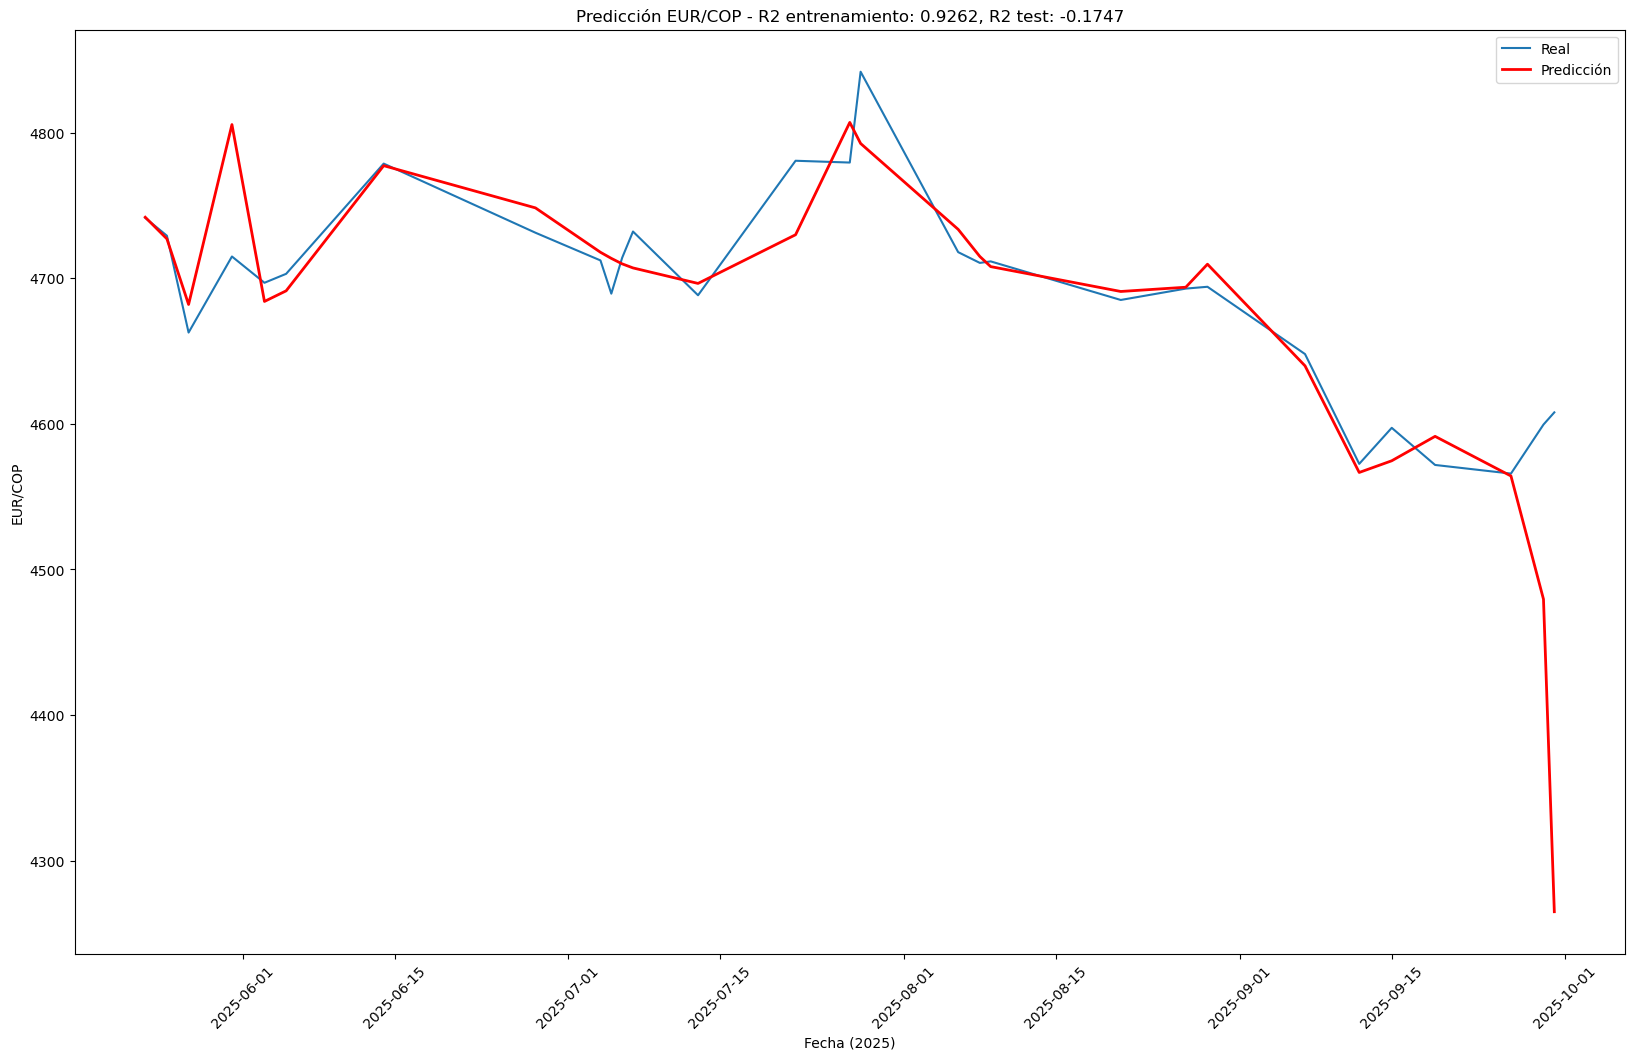

In [161]:
graficar_prediccion_moneda("COP",10)

Regresion para USD con grado de polinomio 10

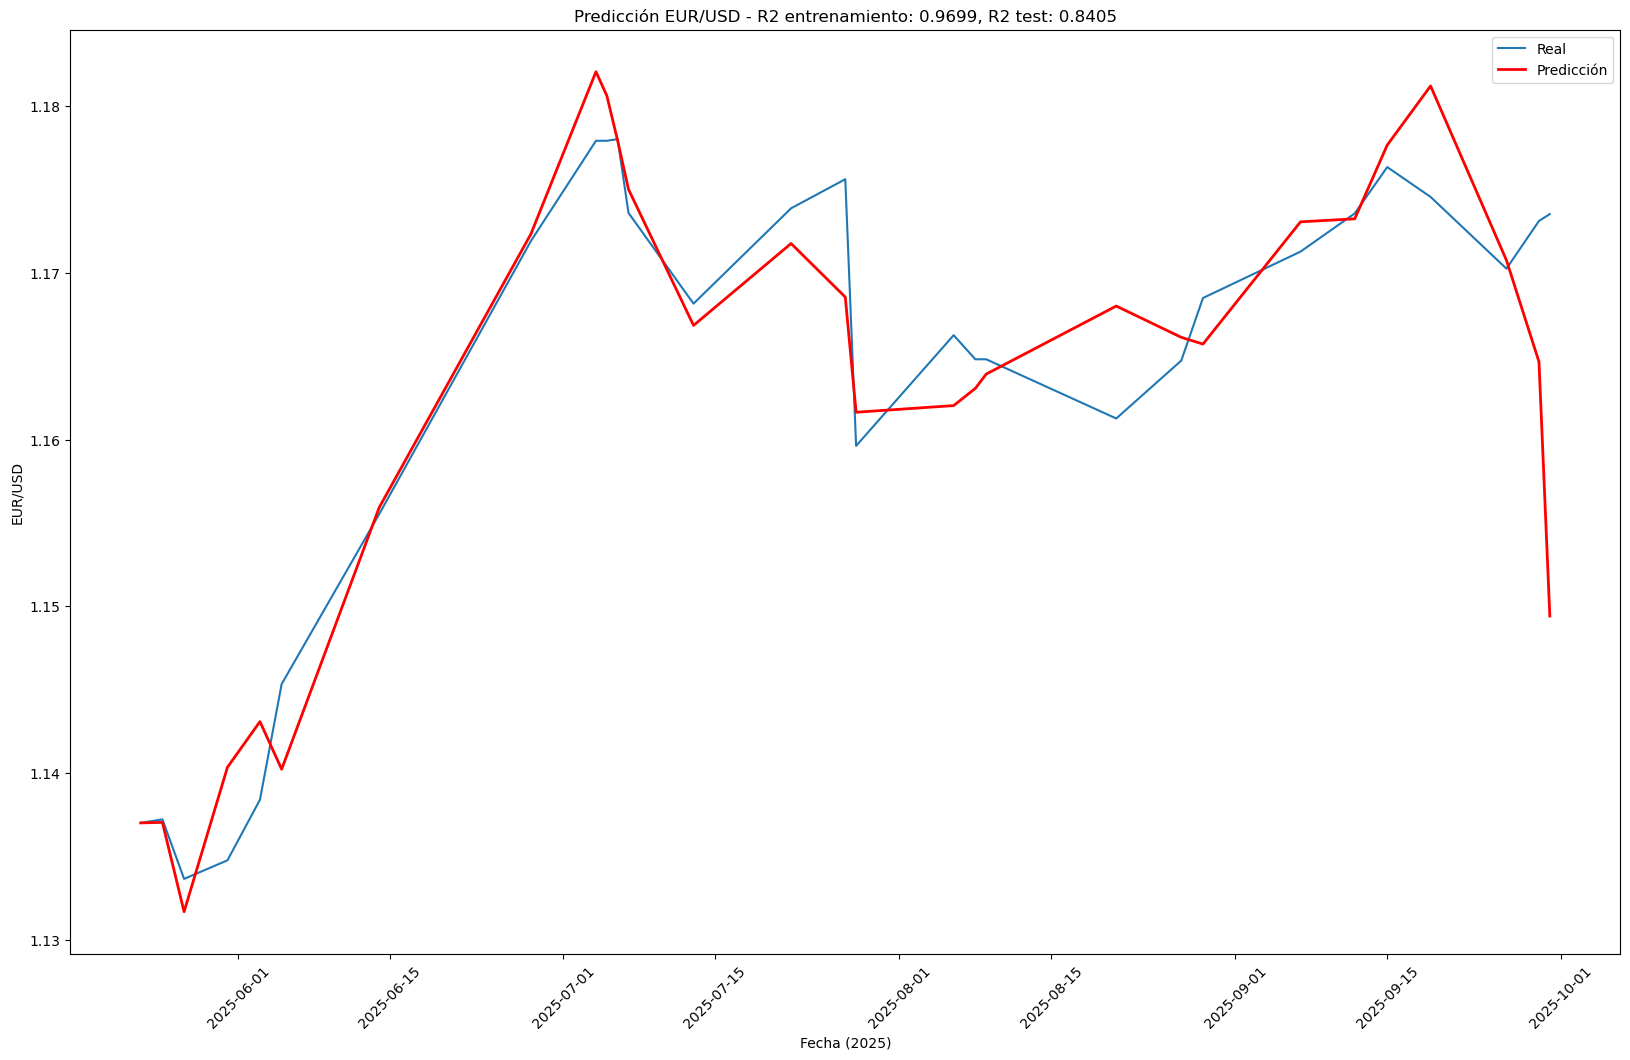

In [162]:
graficar_prediccion_moneda("USD",10)

Regresion para MXN con grado de polinomio 10

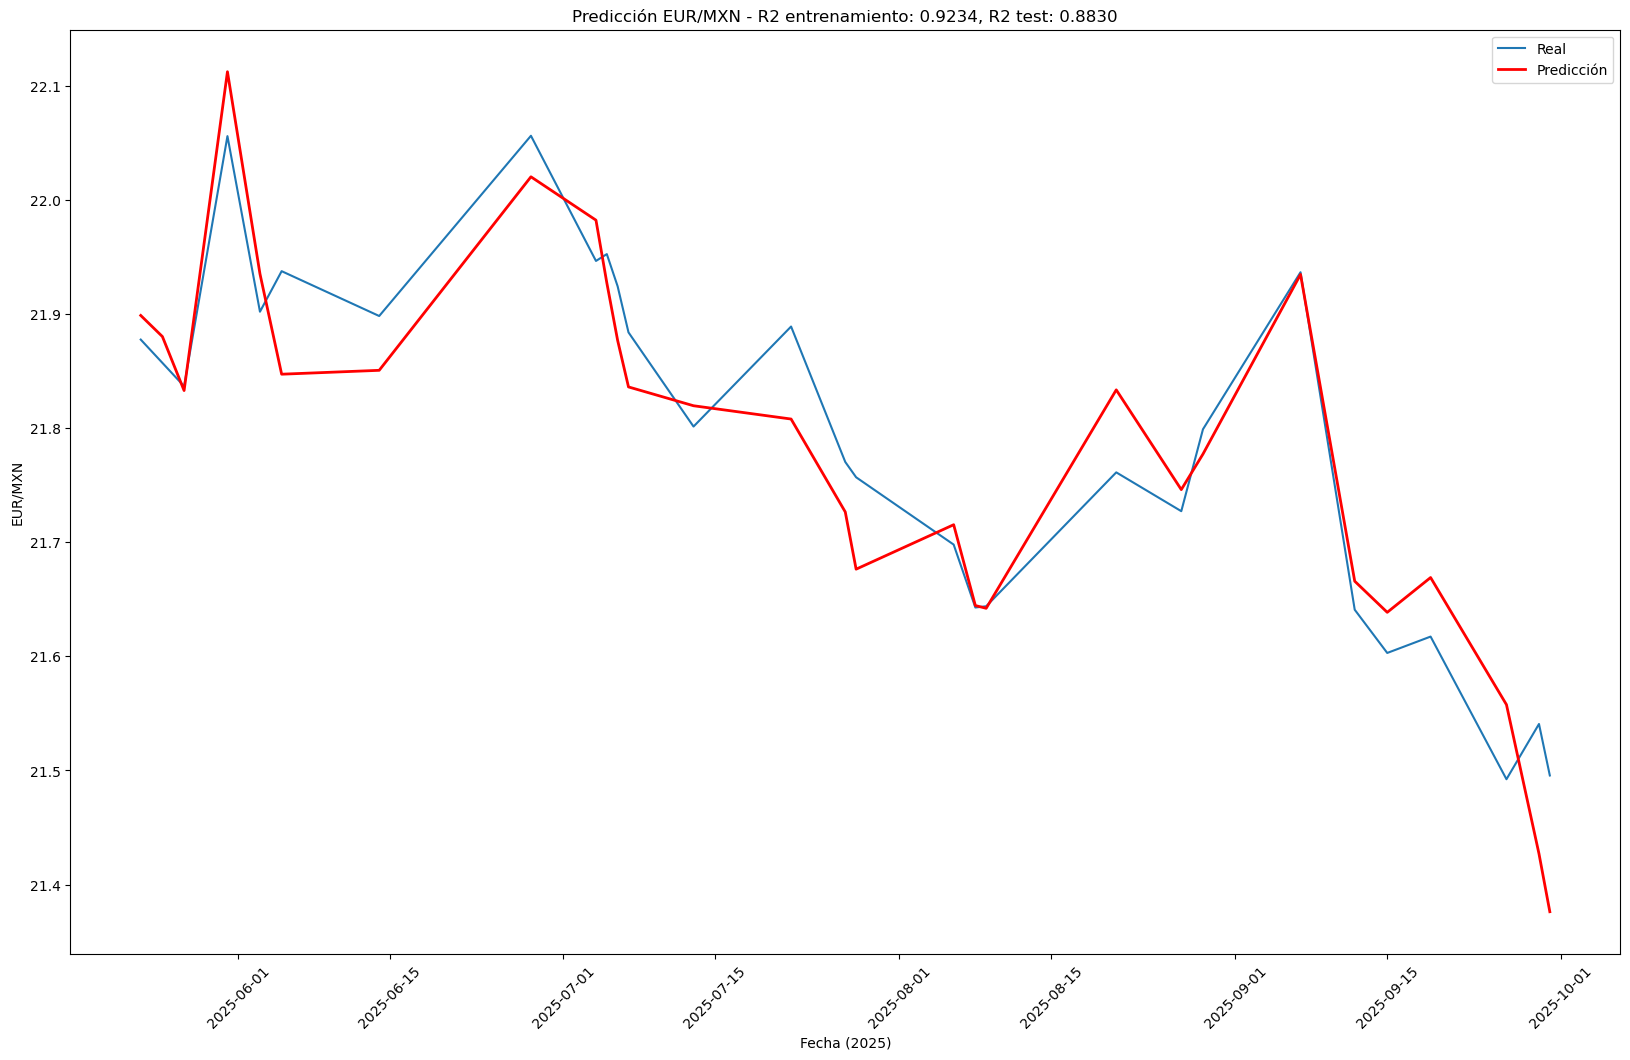

In [163]:
graficar_prediccion_moneda("MXN",10)